# Introduction

We study the problem of learning conditional distribution for multi-model continous variable using mixture density networks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [2]:
sess = tf.Session()

In [3]:
plt.rcParams['figure.figsize'] = (10,10)

$y = 7.0sin(0.75x) + 0.5x + \epsilon$

Text(0, 0.5, 'y')

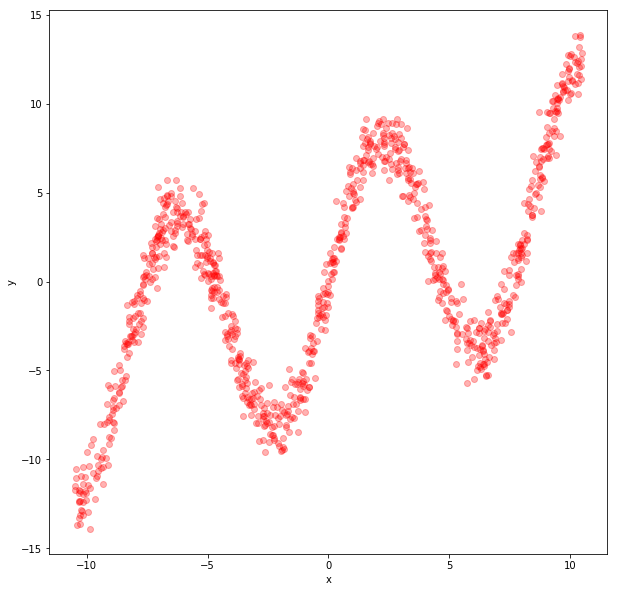

In [4]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (NSAMPLE,1)))
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data)
plt.plot(x_data,y_data,'ro',alpha=0.3);
plt.gca().set_xlabel('x')
plt.gca().set_ylabel('y')

In [5]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])

In [6]:
NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out

In [7]:
lossfunc = tf.nn.l2_loss(y_out-y);

In [8]:
train_op = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(lossfunc)

In [9]:
sess.run(tf.global_variables_initializer())

In [10]:
NEPOCH = 1000
losses = []
for i in range(NEPOCH):
    if (i%100 == 0):
        print('epoch: ', i)
        losses.append(sess.run(lossfunc, feed_dict={x: x_data, y: y_data}))
        print('current loss: ', losses[-1])
    sess.run(train_op,feed_dict={x: x_data, y: y_data})

epoch:  0
current loss:  21689.37
epoch:  100
current loss:  6113.9946
epoch:  200
current loss:  4218.648
epoch:  300
current loss:  3313.786
epoch:  400
current loss:  3098.4822
epoch:  500
current loss:  2467.4243
epoch:  600
current loss:  2514.7979
epoch:  700
current loss:  2258.8345
epoch:  800
current loss:  2186.2297
epoch:  900
current loss:  1829.5898


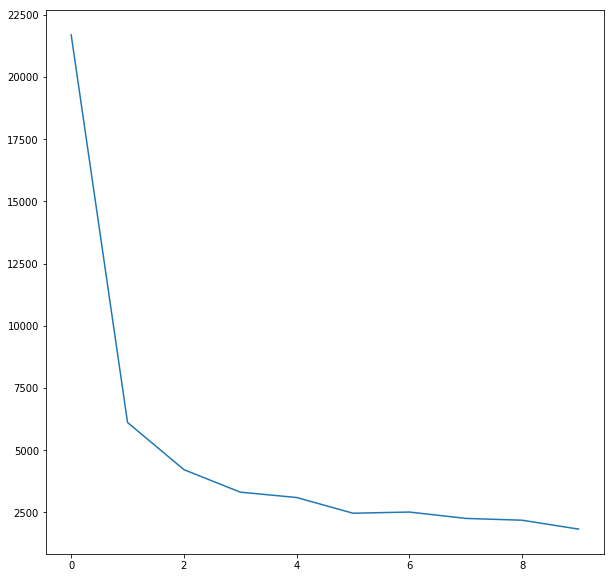

In [11]:
plt.plot(losses)

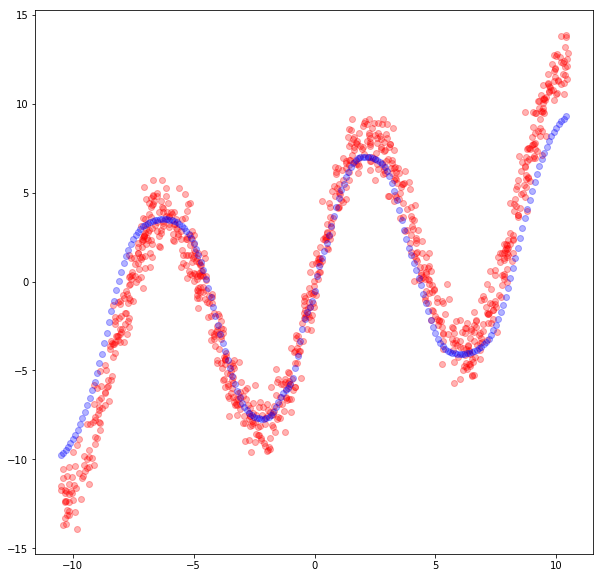

In [12]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

### Invert data

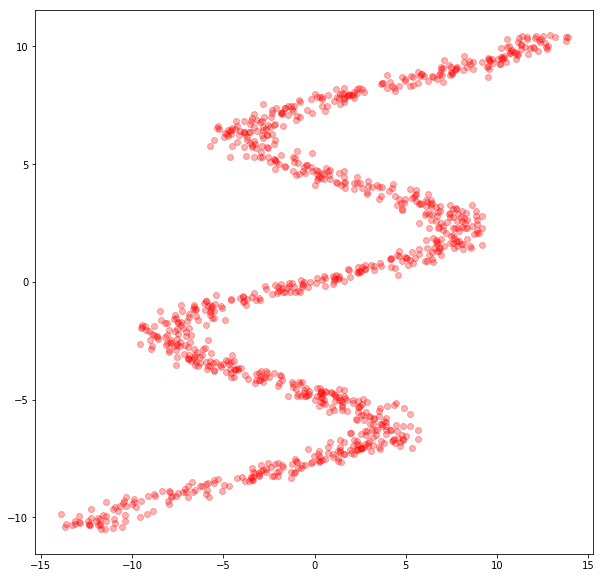

In [13]:
temp_data = x_data
x_data = y_data
y_data = temp_data
plt.plot(x_data,y_data,'ro',alpha=0.3)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

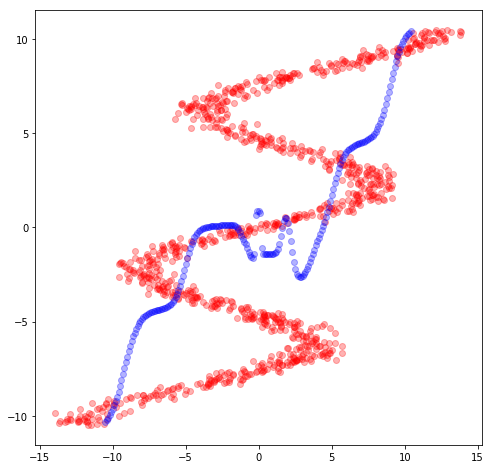

In [15]:
for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})

x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

# Mixture density network

A mixture density network (MDN) models 

In [16]:
NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

def get_mixture_coef(output):
    out_pi, out_sigma, out_mu = tf.split(output, 3, axis=1)

    max_pi = tf.reduce_max(out_pi, 1, keepdims=True)
    out_pi = tf.subtract(out_pi, max_pi)

    out_pi = tf.exp(out_pi)

    normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keepdims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)

    out_sigma = tf.exp(out_sigma)

    return out_pi, out_sigma, out_mu

out_pi, out_sigma, out_mu = get_mixture_coef(output)

Explanation:
    

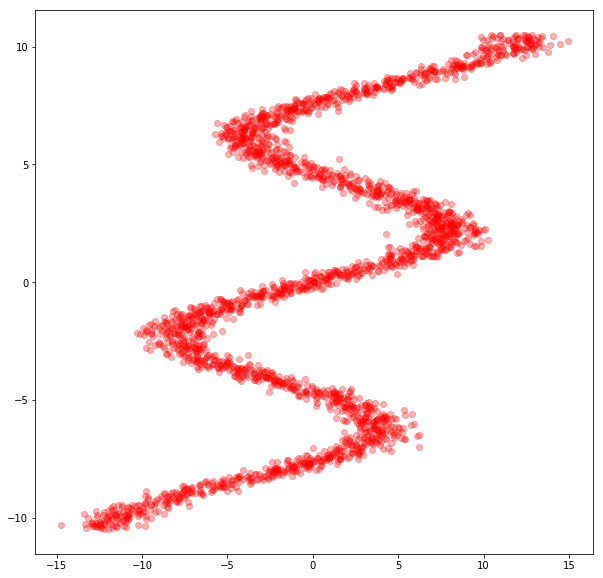

In [17]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.plot(x_data,y_data,'ro', alpha=0.3)

$cost(y|x) = -log\big[\sum_{k=1}^{K}\pi_k(x)\phi(y,\mu(x), \sigma(x)) \big]$

Note that $\pi_k(x), \phi(y,\mu(x), \sigma(x))$ are all computed using MDN

In [18]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def tf_normal(y, mu, sigma):
    result = tf.subtract(y, mu)
    result = tf.multiply(result,tf.reciprocal(sigma))
    result = -tf.square(result)/2
    return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)



In [19]:
lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
# with tf.Session() as sess:
sess.run(tf.global_variables_initializer())

NEPOCH = 20000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):    
    sess.run(train_op,feed_dict={x: x_data, y: y_data})
    loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})
    if (i%500 == 0):
        print('epoch {} - current loss {}'.format(i, loss[i]))

    

epoch 0 - current loss 4.097902774810791
epoch 500 - current loss 1.583475947380066
epoch 1000 - current loss 1.4275695085525513
epoch 1500 - current loss 1.3744250535964966
epoch 2000 - current loss 1.3413186073303223
epoch 2500 - current loss 1.3224555253982544
epoch 3000 - current loss 1.3154945373535156
epoch 3500 - current loss 1.3117116689682007
epoch 4000 - current loss 1.3025809526443481
epoch 4500 - current loss 1.292409896850586
epoch 5000 - current loss 1.2844538688659668
epoch 5500 - current loss 1.277714490890503
epoch 6000 - current loss 1.2768006324768066
epoch 6500 - current loss 1.271569013595581
epoch 7000 - current loss 1.2679895162582397
epoch 7500 - current loss 1.2679890394210815


KeyboardInterrupt: 

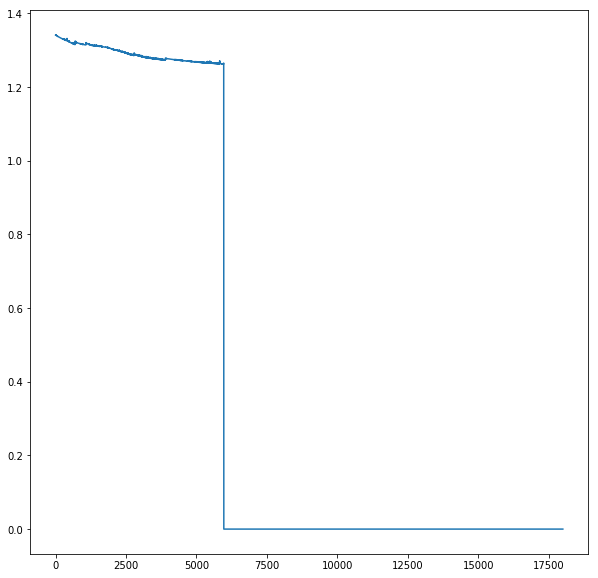

In [21]:
plt.plot(loss[2000:])

In [22]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
    if (accumulate >= x):
        return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 1):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

  # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result

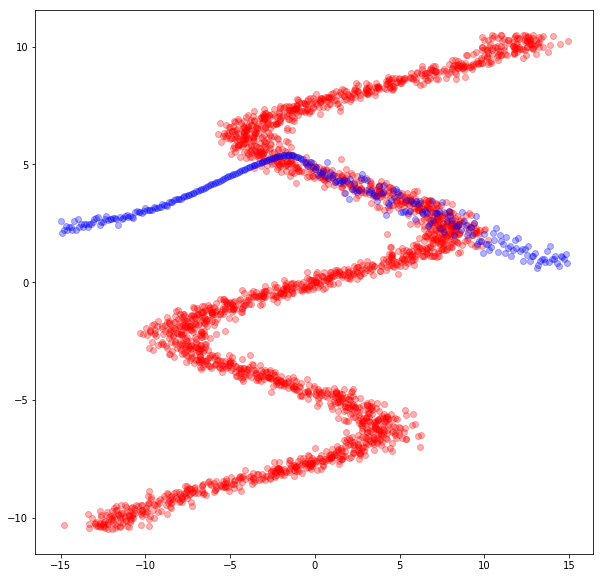

In [23]:
out_pi_test, out_sigma_test, out_mu_test = sess.run(get_mixture_coef(output), feed_dict={x: x_test})
y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)


In [24]:
out_mu_test

array([[-3.8239567 , -1.2768763 , -1.955098  , ..., -0.82814646,
        -8.646486  ,  2.2887425 ],
       [-3.8207512 , -1.2776642 , -1.9517523 , ..., -0.8281036 ,
        -8.639679  ,  2.2972693 ],
       [-3.817462  , -1.2784745 , -1.9483302 , ..., -0.8280504 ,
        -8.632713  ,  2.3059998 ],
       ...,
       [ 2.6153512 ,  1.8519285 ,  2.7151563 , ...,  1.1746118 ,
        10.173605  ,  0.8826505 ],
       [ 2.6256263 ,  1.8584638 ,  2.7047071 , ...,  1.169056  ,
        10.171616  ,  0.8677116 ],
       [ 2.635748  ,  1.8648378 ,  2.6943831 , ...,  1.1635339 ,
        10.169444  ,  0.8530155 ]], dtype=float32)

In [25]:
out_sigma_test

array([[1.3986384e-03, 4.2892540e-01, 3.7161312e+00, ..., 6.5782559e+03,
        4.8258948e+00, 2.0913500e-01],
       [1.3958442e-03, 4.3281630e-01, 3.7115347e+00, ..., 6.5325186e+03,
        4.8381548e+00, 2.0576774e-01],
       [1.3929877e-03, 4.3682522e-01, 3.7068930e+00, ..., 6.4860288e+03,
        4.8508244e+00, 2.0239362e-01],
       ...,
       [5.7319220e+02, 2.9145081e+00, 5.0770774e-02, ..., 2.1566734e-04,
        1.8468326e-01, 1.8362448e-01],
       [5.8497644e+02, 2.9079032e+00, 5.1827934e-02, ..., 2.1520055e-04,
        1.8305631e-01, 1.8139544e-01],
       [5.9684351e+02, 2.9014163e+00, 5.2894522e-02, ..., 2.1474971e-04,
        1.8146580e-01, 1.7920578e-01]], dtype=float32)